In [4]:
import os
for dirname, _, filenames in os.walk('COVID-19_Radiography_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

COVID-19_Radiography_Dataset\COVID\COVID-1.png
COVID-19_Radiography_Dataset\COVID\COVID-10.png
COVID-19_Radiography_Dataset\COVID\COVID-100.png
COVID-19_Radiography_Dataset\COVID\COVID-1000.png
COVID-19_Radiography_Dataset\COVID\COVID-1001.png
COVID-19_Radiography_Dataset\COVID\COVID-1002.png
COVID-19_Radiography_Dataset\COVID\COVID-1003.png
COVID-19_Radiography_Dataset\COVID\COVID-1004.png
COVID-19_Radiography_Dataset\COVID\COVID-1005.png
COVID-19_Radiography_Dataset\COVID\COVID-1006.png
COVID-19_Radiography_Dataset\COVID\COVID-1007.png
COVID-19_Radiography_Dataset\COVID\COVID-1008.png
COVID-19_Radiography_Dataset\COVID\COVID-1009.png
COVID-19_Radiography_Dataset\COVID\COVID-101.png
COVID-19_Radiography_Dataset\COVID\COVID-1010.png
COVID-19_Radiography_Dataset\COVID\COVID-1011.png
COVID-19_Radiography_Dataset\COVID\COVID-1012.png
COVID-19_Radiography_Dataset\COVID\COVID-1013.png
COVID-19_Radiography_Dataset\COVID\COVID-1014.png
COVID-19_Radiography_Dataset\COVID\COVID-1015.png
COVID-1

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import os
from distutils.file_util import copy_file
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau

# Data Preparation

In [10]:
covidDataPath='COVID-19_Radiography_Dataset/COVID'
pneumoniaDataPath='COVID-19_Radiography_Dataset/Viral Pneumonia'
normalDataPath='COVID-19_Radiography_Dataset/Normal'

In [11]:
listCovidPaths = []
listNormalPaths = []

for root, directories, files in os.walk(covidDataPath):
    for name in files:
        listCovidPaths.append(os.path.join(root, name))

for root, directories, files in os.walk(normalDataPath):
    for name in files:
        listNormalPaths.append(os.path.join(root, name))

random.shuffle(listCovidPaths)
random.shuffle(listNormalPaths)

In [12]:
len(listCovidPaths)

3616

In [13]:
len(listNormalPaths)

10192

In [15]:
pathCovidTrain = 'Data/Train/Covid/'
pathCovidTest = 'Data/Test/Covid/'
pathCovidValid='Data/Valid/Covid/'

pathNormalTrain = 'Data/Train/Normal/'
pathNormalTest = 'Data/Test/Normal/'
pathNormalValid='Data/Valid/Normal/'


In [16]:
for i in range(3616):
    if i < 2893:
        copy_file(listCovidPaths[i], pathCovidTrain)
    elif i>=2893 and i<=3255:
        copy_file(listCovidPaths[i], pathCovidValid)
    else  : 
        copy_file(listCovidPaths[i], pathCovidTest)
        
for i in range(10192):
    if i < 8154:
        copy_file(listNormalPaths[i], pathNormalTrain)
    elif i>=8154 and i<=9174:
        copy_file(listNormalPaths[i], pathNormalValid)     
    else  : 
        copy_file(listNormalPaths[i], pathNormalTest)       

# Data Augmentation

In [2]:
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= './Data/Train',
                                           class_mode = 'binary',
                                           batch_size=64,
                                           target_size=(224,224))

Found 11047 images belonging to 2 classes.


In [3]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= './Data/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= './Data/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

Found 1377 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.


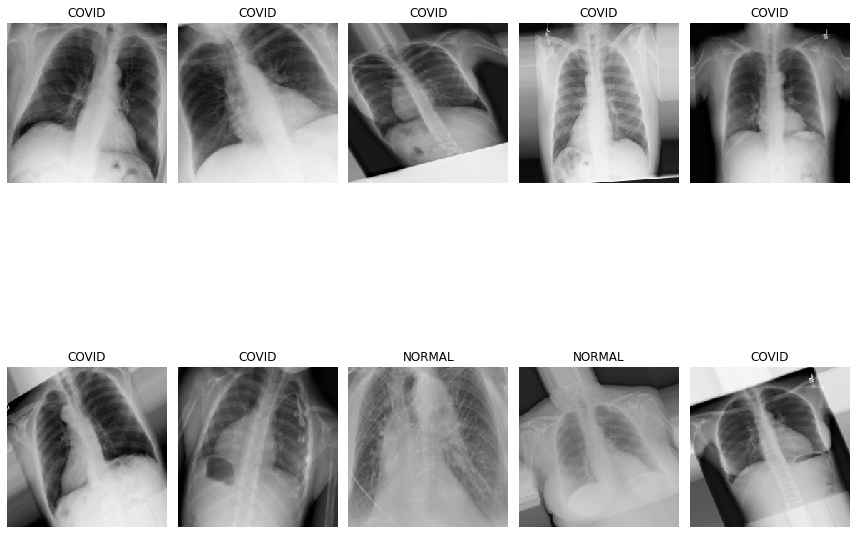

In [4]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Importing Xception

In [5]:
inc = tf.keras.applications.xception.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'softmax'
)

In [6]:
for layer in inc.layers:           
  layer.trainable = False

In [7]:
x = tf.keras.layers.Flatten()(inc.output)
prediction= tf.keras.layers.Dense(1 , activation=tf.nn.sigmoid)(x)

model = tf.keras.Model(inc.input,prediction)

In [8]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9092637400622192, 1: 0.6773975962717684}


In [11]:
hist = model.fit(train, steps_per_epoch= len(train), epochs= 15, validation_data= valid,class_weight=cw,validation_steps= len(test))
model.save("covid19_model_adv.h5")
model.save_weights("covid19_model_weights.h5")
model_json = model.to_json()
with open('covid19_model_adv.json', 'w') as json_file:
    json_file.write(model_json)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/15
173/173 [==============================] - 135s 739ms/step - loss: 0.4412 - accuracy: 0.7956 - val_loss: 0.3222 - val_accuracy: 0.8699
Epoch 2/15
173/173 [==============================] - 128s 739ms/step - loss: 0.3440 - accuracy: 0.8542 - val_loss: 0.2967 - val_accuracy: 0.8887
Epoch 3/15
173/173 [==============================] - 134s 771ms/step - loss: 0.3136 - accuracy: 0.8695 - val_loss: 0.3585 - val_accuracy: 0.8418
Epoch 4/15
173/173 [==============================] - 129s 744ms/step - loss: 0.3055 - accuracy: 0.8766 - val_loss: 0.3410 - val_accuracy: 0.8569
Epoch 5/15
173/173 [==============================] - 129s 744ms/step - loss: 0.2866 - accuracy: 0.8836 - val_loss: 0.4223 - val_accuracy: 0.8143
Epoch 6/15
173/173 [==============================] - 129s 743ms/step - loss: 0.2823 - accuracy: 0.8834 - val_loss: 0.2568 - val_acc


# Results

<AxesSubplot:>

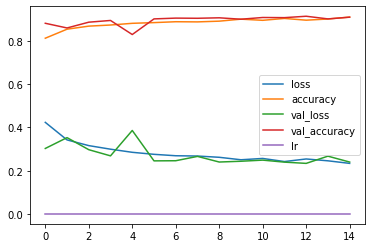

In [12]:
pd.DataFrame(hist.history).plot()

In [13]:
import seaborn as sns

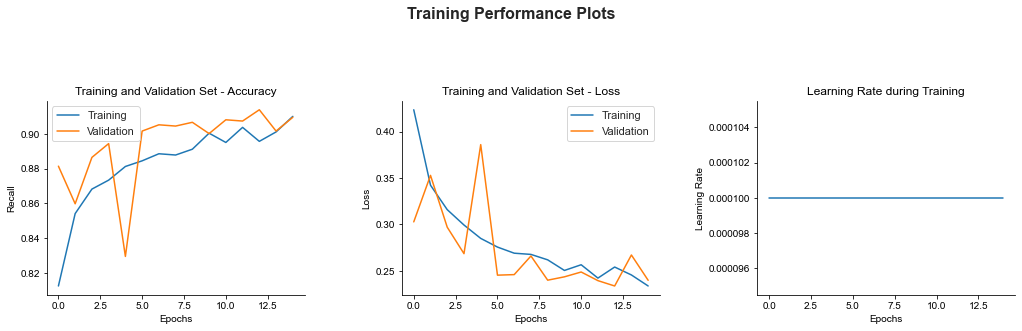

In [14]:
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(hist.history)

ax = sns.lineplot(x =historyDF.index, y = hist.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x =historyDF.index, y = hist.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = hist.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [15]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

22/22 [==============================] - 13s 583ms/step - loss: 0.2149 - accuracy: 0.9216
The testing accuracy is : 92.15686321258545 %


In [16]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

22/22 [==============================] - 5s 210ms/step


## Confusion Matrix

<AxesSubplot:>

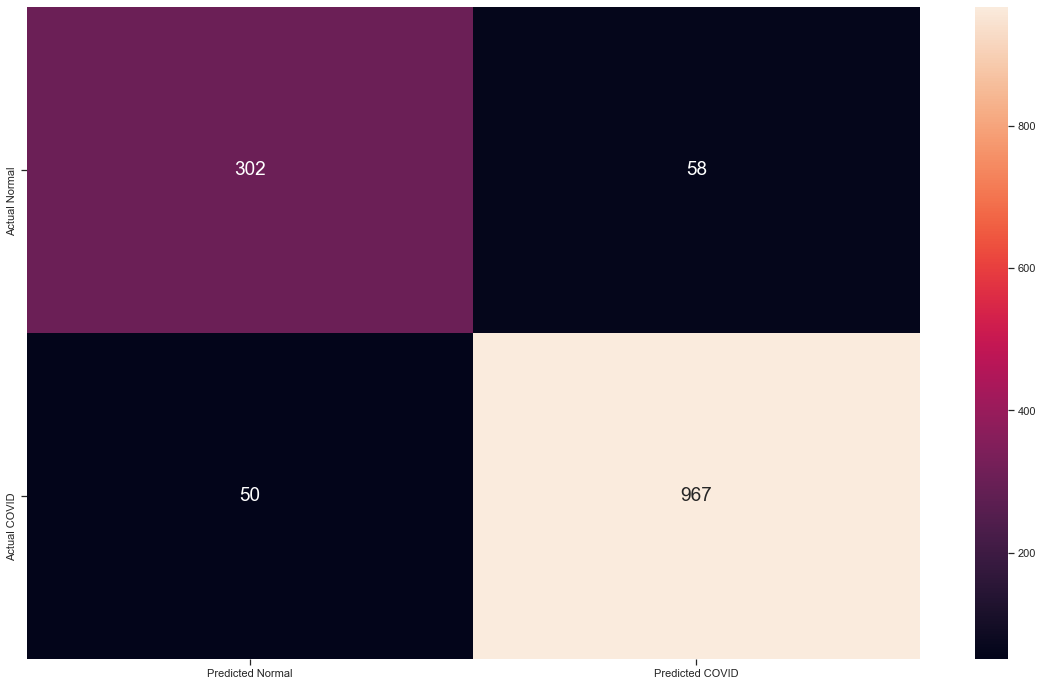

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual COVID"],
columns=["Predicted Normal", "Predicted COVID"])
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams.update({'font.size': 19})
sns.heatmap(cm,annot=True,fmt="d",ax=ax)

In [18]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID']))

              precision    recall  f1-score   support

      NORMAL       0.86      0.84      0.85       360
       COVID       0.94      0.95      0.95      1017

    accuracy                           0.92      1377
   macro avg       0.90      0.89      0.90      1377
weighted avg       0.92      0.92      0.92      1377



In [19]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(1377, 224, 224, 3)
(1377,)


In [20]:
y_true=test.classes

In [21]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


**Overall Results**
Accuracy Result: 92.16%
Precision Result: 94.34%
Recall Result: 95.08%
F-Score Result: 94.71%


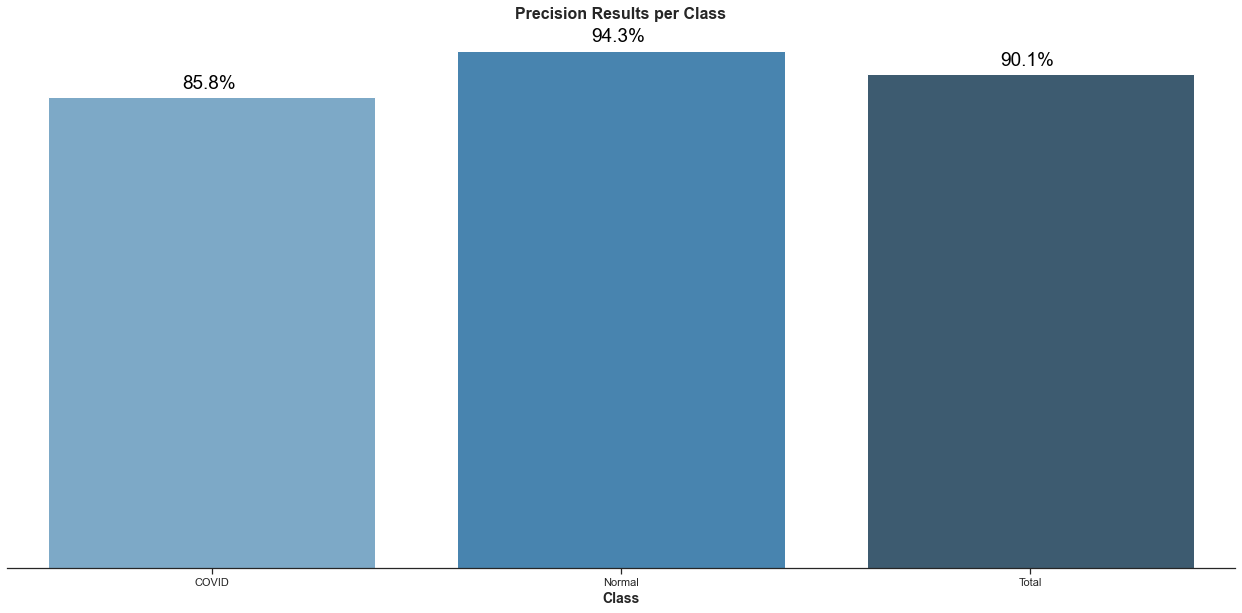

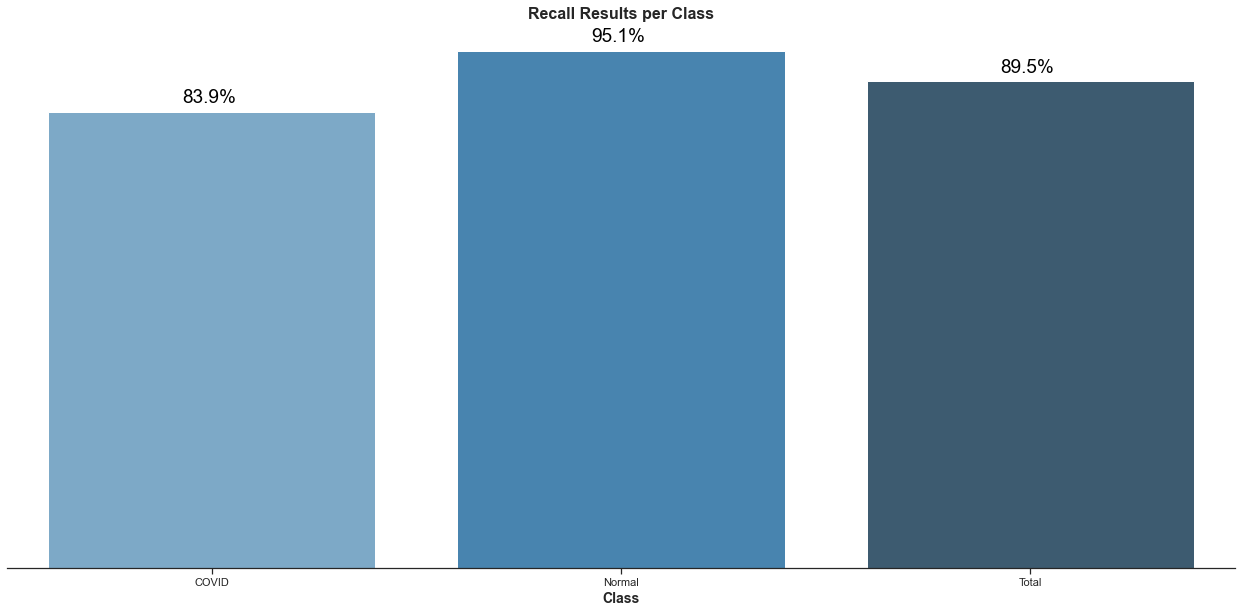

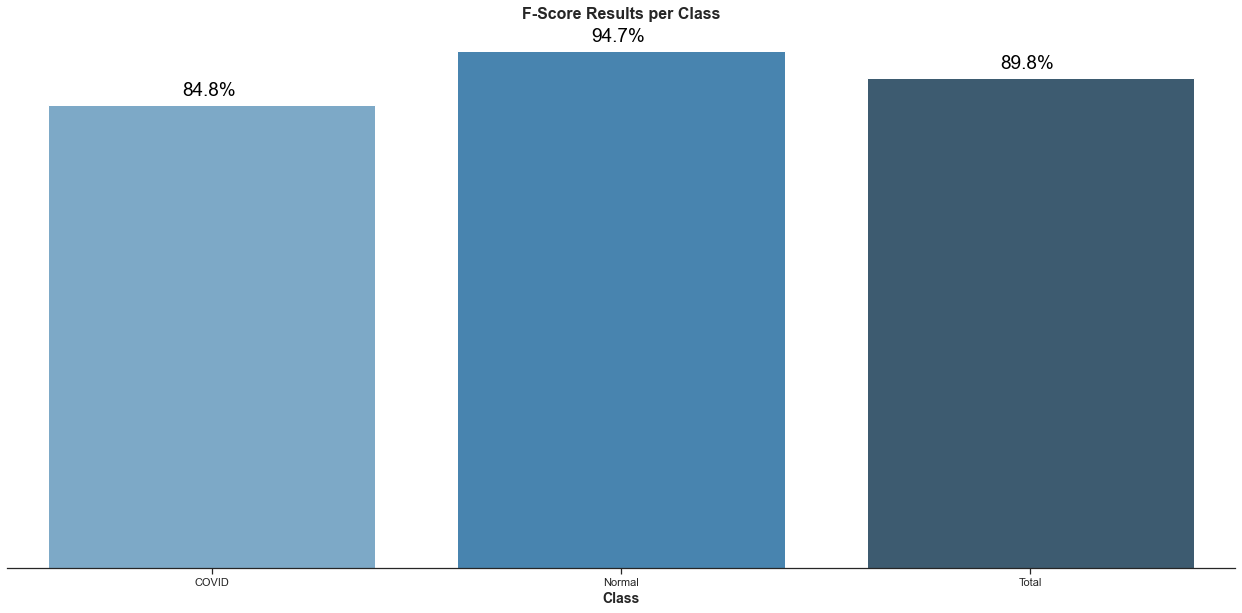

In [22]:
acc = accuracy_score(y_true, predictions)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100))
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))

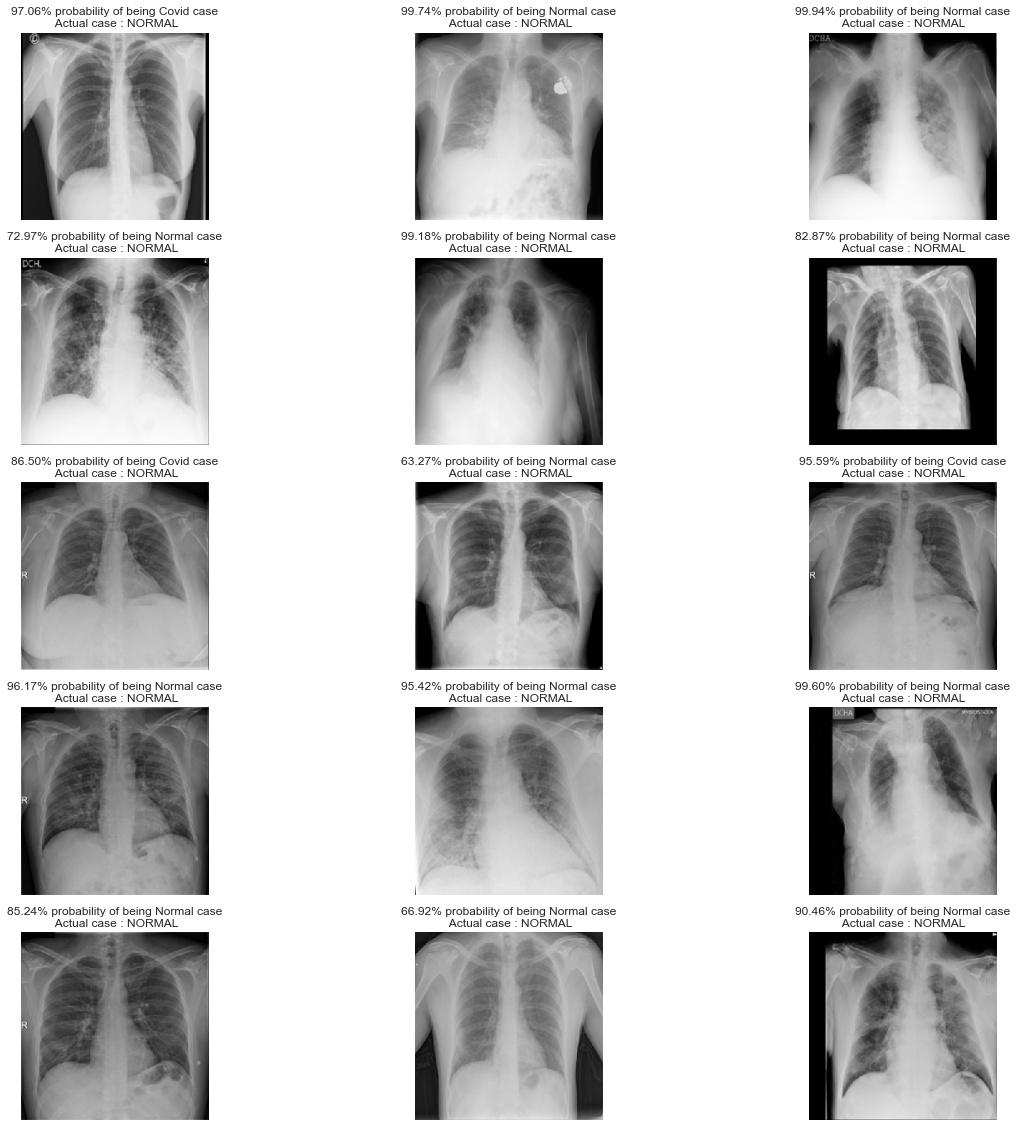

In [23]:
dic = {0:'NORMAL', 1:'COVID'}
plt.figure(figsize=(20,20))
for i in range(0+224, 15+224):
  plt.subplot(5,3, (i-224)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Covid case'.format(preds[i][0]))   
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

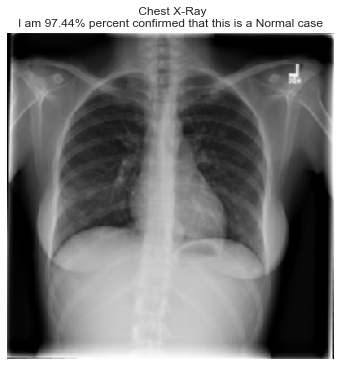

In [26]:
img_path = 'COVID-19_Radiography_Dataset/Normal/Normal-9105.png'
from tensorflow.keras.preprocessing import image
img = image.load_img(img_path, target_size=(224,224))

pp_img = image.img_to_array(img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)

preds= model.predict(pp_img)

plt.figure(figsize=(6,6))
plt.axis('off')
if preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(preds[0][0]))
    
else: 
    out = ('{:.2%} percent confirmed that this is a COVID case'.format(1-preds[0][0]))    

plt.title(" Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_img))
plt.show()

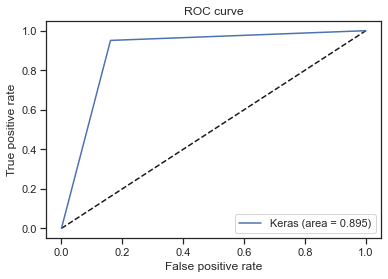

In [25]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test.classes, predictions)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()